**Brian Blaylock**  
**May 15, 2019**

# **Fig. 6.** Scores Spread for hour 22:00 UTC

![](./figs/Fig-06_Score-Spread-Timesereis.png)

> FIG. 6. a) FSS (left), and POD and FAR (right) spread (standard deveation) between F01-F18 for the HRRR domain at 2200 UTC (time of day with approximate maximum lightning) between 1 May 2018 through 1 October 2018. FSS spread is for neighborhood of 120 km radius. Other footprint sizes show similar spread values (not shown). b) as in a) but for west subregion. c) as in a) but for central region. d) as in a but for east subregion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import itertools

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_wx_calcs.binary_events import hit_rate, false_alarm_ratio, base_rate

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7.4,9.6]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['grid.alpha'] = .5
#mpl.rcParams['figure.subplot.wspace'] = 0.15
#mpl.rcParams['figure.subplot.hspace'] = 0.15

mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .95
mpl.rcParams['legend.labelspacing'] = 0.1
mpl.rcParams['legend.handlelength'] = 1
mpl.rcParams['legend.handletextpad'] = 0.5
mpl.rcParams['legend.borderaxespad'] = 0.3
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.columnspacing'] = 1.0

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [3]:
def get_contingency_table_by_hour(HOUR, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
            FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
            data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
    return data_dict

def get_FSS_by_hour(HOUR, radius, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            try:
                DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
                FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
                data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
            except:
                data_dict[DOMAIN][MONTH] = np.ones_like(range(18))*np.nan
    return data_dict

In [4]:
def plot_add_HRRR_version_line(ax, text=True):
    ax.axvline(datetime(2018, 7, 12, 12), linestyle='--', color='k', zorder=0)
    if text:
        ax.text(datetime(2018, 7, 10), .26, 'HRRRv2', fontsize=7, ha='right')
        ax.text(datetime(2018, 7, 15), .26, 'HRRRv3', fontsize=7, ha='left')

In [21]:
def plot_add_FSS_TS(ax, fxx, radii, legend=True):
    for r in radii:
        FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)
        FSS_fxx_ts = []
        ABCD_ts = {'A':[],
                   'B':[],
                   'C':[],
                   'D':[]}
        dates = []
        for m in MONTHS:
            FSS = FSS_all[DOMAIN][m]['F%02d_FSS' % fxx]
            FSS_fxx_ts = list(FSS_fxx_ts) + list(FSS)
            
            for i in ['A', 'B', 'C', 'D']:
                ABCD = Table_all[DOMAIN][m]['F%02d_%s' % (fxx, i)]
                ABCD_ts[i] = list(ABCD_ts[i]) + list(ABCD)

            dates = list(dates) + list(FSS_all[DOMAIN][m]['DATE'])
            # Convert dates string to Datetime object    
            DATES = np.array([])
            for D in dates:
                try:
                    DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
                except:
                    DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
        
        baseRate = base_rate(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))
        FSS_uniform = 0.5 + baseRate/2
        
        plt.sca(ax)
        plt.plot(DATES, FSS_fxx_ts, color='tab:red', label=r'FSS$\mathregular{_{%s}}$ F%02d' % (r*3,fxx), zorder=3)
        plt.plot(DATES, FSS_uniform, color='grey', linestyle='--', label=r'FSS$\mathregular{_{uniform}}$', zorder=1)
        
    if legend: plt.legend(labelspacing=.1).set_zorder(100)

In [31]:
def plot_add_FSS_spred(ax, radii=[40], fxxs=range(1,19), legend=True):
    """fxxs is the range of forecasts to comput the spread"""
    for r in radii:
        plt.sca(ax)
        FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)

        FSS_spread_ts = []
        dates = []
        for m in MONTHS:
            dates = list(dates) + list(FSS_all[DOMAIN][m]['DATE'])
            fss_ts = np.array([FSS_all[DOMAIN][m]['F%02d_FSS' % i] for i in fxxs])
            spread = np.std(fss_ts, axis=0, ddof=1)
            FSS_spread_ts = list(FSS_spread_ts) + list(spread)

        # Convert dates string to Datetime object    
        DATES = np.array([])
        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

        ax.plot(DATES, FSS_spread_ts, zorder=10, color='tab:green', label=r'FSS$\mathregular{_{%s}}$ spread' % (r*3))
    if legend: plt.legend().set_zorder(100)

In [35]:
def plot_add_POD_FAR_spred(ax, fxxs=range(1,19), legend=True):
    POD_spread_ts = []
    FAR_spread_ts = []
    dates = []
    for m in MONTHS:
        dates = list(dates) + list(Table_all[DOMAIN][m]['DATE'])
        A = np.array([Table_all[DOMAIN][m]['F%02d_A' % i] for i in fxxs])
        B = np.array([Table_all[DOMAIN][m]['F%02d_B' % i] for i in fxxs])
        C = np.array([Table_all[DOMAIN][m]['F%02d_C' % i] for i in fxxs])
        D = np.array([Table_all[DOMAIN][m]['F%02d_D' % i] for i in fxxs])

        POD = hit_rate(A, B, C, D)
        FAR = false_alarm_ratio(A, B, C, D)

        POD_spread = np.std(POD, axis=0, ddof=1)
        FAR_spread = np.std(FAR, axis=0, ddof=1)

        POD_spread_ts = list(POD_spread_ts) + list(POD_spread)
        FAR_spread_ts = list(FAR_spread_ts) + list(FAR_spread)

    # Convert dates string to Datetime object    
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

    plt.sca(ax)
    plt.plot(DATES, FAR_spread_ts, zorder=1, label='FAR spread')
    plt.plot(DATES, POD_spread_ts, zorder=1, label='POD spread')

    if legend: plt.legend().set_zorder(100)
    

Radius r[20] = [60] km


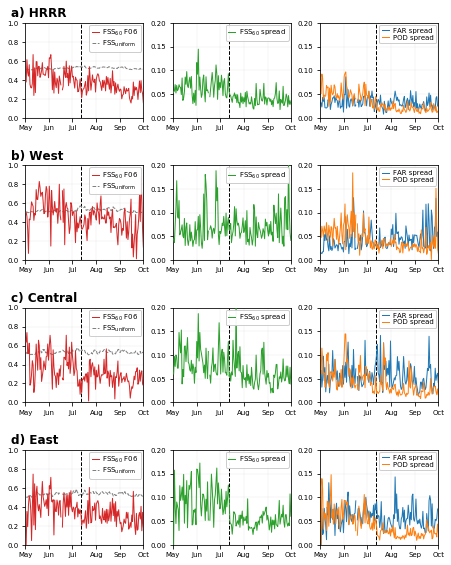

In [37]:
fig, axes = plt.subplots(4,3)

domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']
HOUR = 22
MONTHS = range(5,10)
radii = [20]
print('Radius r%s = %s km' % (radii, np.array(radii)*3))
FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=radii)
Table_all = get_contingency_table_by_hour(HOUR, MONTHS=MONTHS)

for ax, DOMAIN, label in zip(axes, domains, labels):
    ax[0].set_title('%s %s' % (label,DOMAIN), loc='left',
                    fontweight='bold', fontsize=12,
                    position=(-.12,1))
        
    plot_add_FSS_TS(ax[0], fxx=6, radii=radii)
    plot_add_FSS_spred(ax[1], radii=radii, fxxs=range(3,19))
    plot_add_POD_FAR_spred(ax[2], fxxs=range(3,19))
    
    
    plot_add_HRRR_version_line(ax[0], text=False)
    plot_add_HRRR_version_line(ax[1], text=False)
    plot_add_HRRR_version_line(ax[2], text=False)
    
    for i, a in enumerate(ax):
        a.set_xlim([datetime(2018, 5, 1), datetime(2018, 10, 1)])
        if i == 0:
            a.set_ylim([0,1])
        else:
            a.set_ylim([0,.2])
        formatter = DateFormatter('%b')
        a.xaxis.set_major_formatter(formatter)
        a.xaxis.set_major_locator(mdates.DayLocator([1]))
        a.grid(zorder=0)
    
#fig.tight_layout()
fig.subplots_adjust(wspace=.25, hspace=.5)

plt.savefig('./figs/Fig-06_Score-Spread-Timesereis')